# INF 552 HW4 - Chao Chen

## Question 1

In [1]:
import sys
import pandas as pd
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.metrics import confusion_matrix, precision_score, f1_score
from sklearn.preprocessing import Imputer
import scipy.stats as stats
import math


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### (a)

In [2]:
names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df = pd.read_csv('data_banknote_authentication.txt', header=None, names=names, na_values=["?"])

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=472, random_state=1)

### (b)

***(i)***

In [4]:
from sklearn.svm import LinearSVC
df_train_x = df_train[df_train.columns[:-1]]
df_train_y = df_train[df_train.columns[-1:]]
df_test_x = df_test[df_test.columns[:-1]]
df_test_y = df_test[df_test.columns[-1:]]

# found good range is 1e-3 to 1e300
# svc1 = LinearSVC(penalty='l1', C=1e100, dual=False)
# print(svc1.fit(df_train_x, df_train_y).score(df_test_x, df_test_y))
log_lbd = np.linspace(-3, 100, num=20, dtype=np.int32)
print(log_lbd)
lbd = np.power(10, log_lbd.astype(float))
print(lbd)

[ -3   2   7  13  18  24  29  34  40  45  51  56  62  67  72  78  83  89
  94 100]
[  1.00000000e-003   1.00000000e+002   1.00000000e+007   1.00000000e+013
   1.00000000e+018   1.00000000e+024   1.00000000e+029   1.00000000e+034
   1.00000000e+040   1.00000000e+045   1.00000000e+051   1.00000000e+056
   1.00000000e+062   1.00000000e+067   1.00000000e+072   1.00000000e+078
   1.00000000e+083   1.00000000e+089   1.00000000e+094   1.00000000e+100]


In [5]:
from sklearn.model_selection import GridSearchCV

test_errors1 = np.zeros((50, 90))
                        
for i in range(50):
    cur_train = pd.DataFrame()
    sub_df_train = df
    for j in range(90):
        sub_df_train, sub_cur_train = train_test_split(sub_df_train, test_size=10, random_state=1) 
        cur_train = pd.concat([cur_train, sub_cur_train])
        svc = LinearSVC(penalty='l1', dual=False)
        params = {'C': lbd}
        
        cur_train_x, cur_train_y = cur_train[cur_train.columns[:-1]], cur_train[cur_train.columns[-1:]]
        cv_n = min(cur_train_y.shape[0], cur_train_y.sum()[0], 10)
        clf = GridSearchCV(svc, cv=cv_n, param_grid=params, refit=True)
        clf.fit(cur_train_x, cur_train_y)
        
        best_svc = clf.best_estimator_
        best_svc.fit(cur_train_x, cur_train_y)
        test_errors1[i, j] = 1 - best_svc.score(df_test_x, df_test_y)

***(ii)***

In [45]:
from sklearn.svm import SVC
test_errors2 = np.zeros((50, 90))
                        
for i in range(50):
    cur_train = pd.DataFrame()
    sub_df_train = df
    sub_df_train, sub_cur_train = train_test_split(sub_df_train, test_size=10, random_state=1) 
    for j in range(90):
        cur_train = pd.concat([cur_train, sub_cur_train])
        svc = LinearSVC(penalty='l1', dual=False)
        params = {'C': lbd}
        
        cur_train_x, cur_train_y = cur_train[cur_train.columns[:-1]], cur_train[cur_train.columns[-1:]]
        cv_n = min(cur_train_y.shape[0], cur_train_y.sum()[0], 10)
        clf = GridSearchCV(svc, cv=cv_n, param_grid=params, refit=True)
        clf.fit(cur_train_x, cur_train_y)
        
        best_svc = clf.best_estimator_
        best_svc.fit(cur_train_x, cur_train_y)
        test_errors2[i, j] = 1 - best_svc.score(df_test_x, df_test_y)
        
        #find 10 closest points
        sub_df_train_x = sub_df_train[sub_df_train.columns[:-1]]
        dists = np.abs(best_svc.decision_function(sub_df_train_x))
        sub_cur_train = sub_df_train.iloc[dists.argsort()[:10]]
    
        

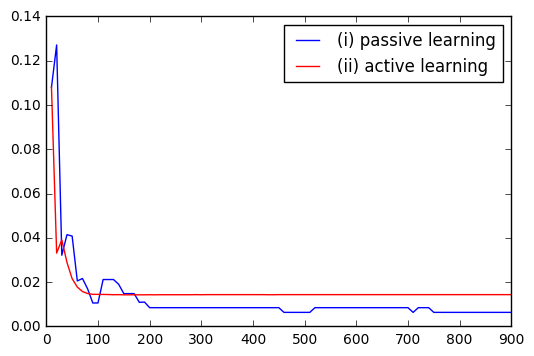

In [47]:
mean_test_error1 = test_errors1.mean(axis=0)
mean_test_error2 = test_errors2.mean(axis=0)
num_train = np.arange(10, 910, 10)

fig, ax = plt.subplots()
ax.plot(num_train, mean_test_error1, '-', color='blue', label='(i) passive learning')
ax.plot(num_train, mean_test_error2, '-', color='red', label='(ii) active learning')
ax.legend()




***Conclusions***:

1. As the number of training instances increases, the average test error for both passive and active learning first decreases significantly and then become relatively stable.

2. The test error of passive learning fluctuates more than active learning. Active learning is more stable.

3. The test errors become relatively stable when number of instances is greater than 100.

# Question 2

### (a)

In [48]:
df2 = pd.read_csv('./Anuran Calls (MFCCs)/Frogs_MFCCs.csv', header=0)
df2_train, df2_test = train_test_split(df2, test_size=0.3, random_state=1)

In [56]:
train_family = df2_train[df2_train.columns[-4]]
train_genus = df2_train[df2_train.columns[-3]]
train_species = df2_train[df2_train.columns[-2]]
df2_train_x = df2_train[df2_train.columns[:-4]]

test_family = df2_test[df2_test.columns[-4]]
test_genus = df2_test[df2_test.columns[-3]]
test_species = df2_test[df2_test.columns[-2]]
df2_test_x = df2_test[df2_test.columns[:-4]]

### (b)

***(i)***

Exact match is the proporation of labels that are exactly correct.

Hamming loss is the fraction of the wrong labels to the total number of labels.

***(ii)***

In [59]:
# use both exact match and Hamming loss
svc_family = SVC(decision_function_shape='ovr', kernel='rbf')
gamma_list = np.arange(0.1, 2.1, 0.1)
params2 = {'C': lbd, 'gamma': gamma_list}
clf_family = GridSearchCV(svc_family, cv=10, param_grid=params2, refit=True)
clf_family.fit(df2_train_x, train_family)

best_svc_family = clf_family.best_estimator_
best_svc_family.fit(df2_train_x, train_family)
pred_family = best_svc_family.predict(df2_test_x)

In [60]:
svc_genus = SVC(decision_function_shape='ovr', kernel='rbf')
clf_genus = GridSearchCV(svc_genus, cv=10, param_grid=params2, refit=True)
clf_genus.fit(df2_train_x, train_genus)

best_svc_genus = clf_genus.best_estimator_
best_svc_genus.fit(df2_train_x, train_genus)
pred_genus = best_svc_genus.predict(df2_test_x)

In [61]:
svc_spc = SVC(decision_function_shape='ovr', kernel='rbf')
clf_spc = GridSearchCV(svc_spc, cv=10, param_grid=params2, refit=True)
clf_spc.fit(df2_train_x, train_species)

best_svc_spc = clf_spc.best_estimator_
best_svc_spc.fit(df2_train_x, train_species)
pred_spc = best_svc_spc.predict(df2_test_x)

In [84]:
from sklearn.metrics import accuracy_score, hamming_loss
exact_match2 = (accuracy_score(test_family, pred_family) + accuracy_score(test_genus, pred_genus) + accuracy_score(test_species, pred_spc))/3
hamming_loss2 = (hamming_loss(test_family, pred_family) + hamming_loss(test_genus, pred_genus) + hamming_loss(test_species, pred_spc))/3

print('Exact match score:' + str(exact_match2))
print('Hamming loss:' + str(hamming_loss2))

Exact match score:0.989501312336
Hamming loss:0.010498687664


***(iii)***

In [67]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
df2_train_x_norm = scl.fit_transform(df2_train_x)
df2_test_x_norm = scl.transform(df2_test_x)

In [70]:
svc_family3 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_family3 = GridSearchCV(svc_family3, cv=10, param_grid=params, refit=True)
clf_family3.fit(df2_train_x_norm, train_family)

best_svc_family3 = clf_family3.best_estimator_
best_svc_family3.fit(df2_train_x_norm, train_family)
pred_family3 = best_svc_family3.predict(df2_test_x_norm)

In [71]:
svc_genus3 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_genus3 = GridSearchCV(svc_genus3, cv=10, param_grid=params, refit=True)
clf_genus3.fit(df2_train_x_norm, train_genus)

best_svc_genus3 = clf_genus3.best_estimator_
best_svc_genus3.fit(df2_train_x_norm, train_genus)
pred_genus3 = best_svc_genus3.predict(df2_test_x_norm)

In [72]:
svc_spc3 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_spc3 = GridSearchCV(svc_spc3, cv=10, param_grid=params, refit=True)
clf_spc3.fit(df2_train_x_norm, train_species)

best_svc_spc3 = clf_spc3.best_estimator_
best_svc_spc3.fit(df2_train_x_norm, train_species)
pred_spc3 = best_svc_spc3.predict(df2_test_x_norm)

In [85]:
exact_match3 = (accuracy_score(test_family, pred_family3) + accuracy_score(test_genus, pred_genus3) + accuracy_score(test_species, pred_spc3))/3
hamming_loss3 = (hamming_loss(test_family, pred_family3) + hamming_loss(test_genus, pred_genus3) + hamming_loss(test_species, pred_spc3))/3

print('Exact match score:' + str(exact_match3))
print('Hamming loss:' + str(hamming_loss3))

Exact match score:0.946117029489
Hamming loss:0.053882970511


***(iv)***

In [86]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_family_sm, y_family_sm = smote.fit_sample(df2_train_x_norm, train_family)

svc_family4 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_family4 = GridSearchCV(svc_family4, cv=10, param_grid=params, refit=True)
clf_family4.fit(x_family_sm, y_family_sm)

best_svc_family4 = clf_family4.best_estimator_
best_svc_family4.fit(x_family_sm, y_family_sm)
pred_family4 = best_svc_family4.predict(df2_test_x_norm)

In [87]:
smote = SMOTE()
x_genus_sm, y_genus_sm = smote.fit_sample(df2_train_x_norm, train_genus)

svc_genus4 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_genus4 = GridSearchCV(svc_genus4, cv=10, param_grid=params, refit=True)
clf_genus4.fit(x_genus_sm, y_genus_sm)

best_svc_genus4 = clf_genus4.best_estimator_
best_svc_genus4.fit(x_genus_sm, y_genus_sm)
pred_genus4 = best_svc_genus4.predict(df2_test_x_norm)

In [88]:
smote = SMOTE()
x_spc_sm, y_spc_sm = smote.fit_sample(df2_train_x_norm, train_species)

svc_spc4 = LinearSVC(penalty='l1', multi_class='ovr', dual=False)
clf_spc4 = GridSearchCV(svc_spc4, cv=10, param_grid=params, refit=True)
clf_spc4.fit(x_spc_sm, y_spc_sm)

best_svc_spc4 = clf_spc4.best_estimator_
best_svc_spc4.fit(x_spc_sm, y_spc_sm)
pred_spc4 = best_svc_spc4.predict(df2_test_x_norm)

In [89]:
exact_match4 = (accuracy_score(test_family, pred_family4) + accuracy_score(test_genus, pred_genus4) + accuracy_score(test_species, pred_spc4))/3
hamming_loss4 = (hamming_loss(test_family, pred_family4) + hamming_loss(test_genus, pred_genus4) + hamming_loss(test_species, pred_spc4))/3

print('Exact match score:' + str(exact_match4))
print('Hamming loss:' + str(hamming_loss4))

Exact match score:0.935927126756
Hamming loss:0.0640728732438


***Conclusions:***

1. The exact match score of using Gaussian kernel in (ii) is smaller than the other two.

2. The hamming loss of using L1-penalized SVM is smaller.

3. SMOTE does not increase the performance of L1-penalized SVM in this case.

## Question 3

In [120]:
scl = StandardScaler()

df2_family = df2[df2.columns[-4]]
df2_genus = df2[df2.columns[-3]]
df2_species = df2[df2.columns[-2]]
df2_x = df2[df2.columns[:-4]]

df2_x_norm = scl.fit_transform(df2_x)

In [121]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
df2_family_le = le.fit_transform(df2_family)
df2_genus_le = le.fit_transform(df2_genus)
df2_spc_le = le.fit_transform(df2_species)

In [124]:
from sklearn.metrics import calinski_harabaz_score
from sklearn.cluster import KMeans

ham_dist = np.zeros(50)

for h in range(50):
    CH_list = []
    k_range = np.arange(2, 21, 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='random')
        pred = kmeans.fit_predict(df2_x_norm)
        CH_list.append(calinski_harabaz_score(df2_x_norm, pred))

    best_k = k_range[np.argmax(CH_list)]
    best_kmeans = KMeans(n_clusters=best_k, init='random')
    best_kmeans.fit(df2_x_norm)

    pred_family5 = np.zeros(df2_family_le.shape[0])
    pred_genus5 = np.zeros(df2_family_le.shape[0])
    pred_spc5 = np.zeros(df2_family_le.shape[0])

    for i in range(best_k):
        ind = np.where(best_kmeans.labels_ == i)[0]
        family_lab = df2_family_le[ind]
        genus_lab = df2_genus_le[ind]
        spc_lab = df2_spc_le[ind]

        pred_family5[ind] = np.bincount(family_lab).argmax()
        pred_genus5[ind] = np.bincount(genus_lab).argmax()
        pred_spc5[ind] = np.bincount(spc_lab).argmax()

    hamming_loss5 = (hamming_loss(df2_family_le, pred_family5) + hamming_loss(df2_genus_le, pred_genus5) + hamming_loss(df2_spc_le, pred_spc5))/3
    ham_dist[h] = hamming_loss5

    

In [126]:
print("Avergae of Hamming Distances: " + str(np.mean(ham_dist)))
print("Standard deviation of Hamming Distances: " + str(np.std(ham_dist)))

Avergae of Hamming Distances: 0.298031040074
Standard deviation of Hamming Distances: 5.55111512313e-17


## Question 4 (ISLR 10.7.2)

### (a)

{'color_list': ['g', 'r', 'b'],
 'dcoord': [[0.0, 0.44721359549995793, 0.44721359549995793, 0.0],
  [0.0, 0.76485292703891772, 0.76485292703891772, 0.0],
  [0.44721359549995793,
   1.2010412149464313,
   1.2010412149464313,
   0.76485292703891772]],
 'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'ivl': [1, 2, 3, 4],
 'leaves': [0, 1, 2, 3]}

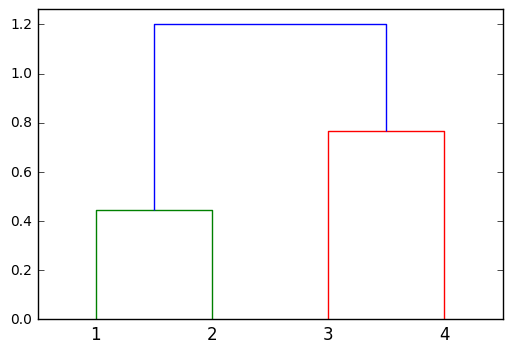

In [108]:
from scipy.cluster.hierarchy import dendrogram, linkage
d = np.matrix([[0, 0.3, 0.4, 0.7], [0.3, 0, 0.5, 0.8], [0.4, 0.5, 0, 0.45], [0.7, 0.8, 0.45, 0]])
z = linkage(d, method='complete')
dendrogram(z, labels=[1,2,3,4])

### (b)

{'color_list': ['g', 'b', 'b'],
 'dcoord': [[0.0, 0.44721359549995793, 0.44721359549995793, 0.0],
  [0.0, 0.65000000000000002, 0.65000000000000002, 0.44721359549995793],
  [0.0, 0.76485292703891772, 0.76485292703891772, 0.65000000000000002]],
 'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'ivl': [4, 3, 1, 2],
 'leaves': [3, 2, 0, 1]}

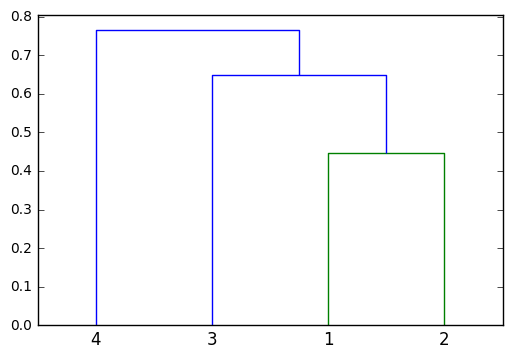

In [109]:
z2 = linkage(d, method='single')
dendrogram(z2, labels=[1,2,3,4])

### (c)
1st and 2nd observations are in one cluster. 

3rd and 4th observations are in the other cluster.

### (d)
1st, 2nd and 3rd observations are in one cluster.

4th observation is in the other cluster.


### (e)

{'color_list': ['g', 'r', 'b'],
 'dcoord': [[0.0, 0.44721359549995793, 0.44721359549995793, 0.0],
  [0.0, 0.76485292703891772, 0.76485292703891772, 0.0],
  [0.44721359549995793,
   1.2010412149464313,
   1.2010412149464313,
   0.76485292703891772]],
 'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'ivl': [2, 1, 4, 3],
 'leaves': [0, 1, 2, 3]}

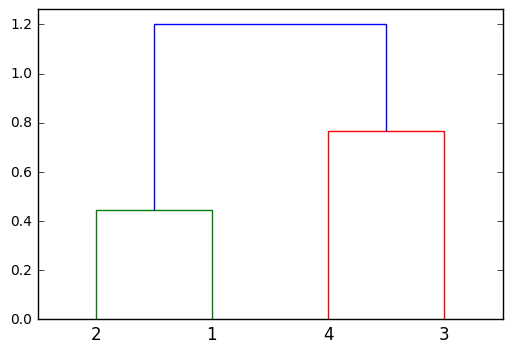

In [110]:
dendrogram(z, labels=[2,1,4,3])